# Summary
This tutorial demonstrates the construction of deep neural network classifiers in Pylearn2. We use the Supersymmetry (SUSY) dataset from Baldi et. al. 2014, "Searching for exotic particles in high-energy physics with deep learning." The full dataset is available at the UCI Machine Learning Repository, and pylearn2 code to replicate the experiments are availalbe on github. In this tutorial, we will use a small subset of the data for portability.

https://archive.ics.uci.edu/ml/datasets/SUSY


In [1]:
import sys
import os
import pickle
import numpy
import theano
print theano.config.device

import pylearn2
import pylearn2.datasets
import pylearn2.training_algorithms
import pylearn2.training_algorithms.sgd
import pylearn2.costs
import pylearn2.costs.mlp.dropout
import pylearn2.models.mlp as mlp
import pylearn2.train
import pylearn2.termination_criteria
import matplotlib
%matplotlib inline

gpu


Using gpu device 0: Tesla C2070 (CNMeM is disabled)


# Data set
A Pylearn2 dataset object can be created from a numpy array. The input data $X$ is given by a $N$-by-$D$ matrix, where $N$ is the number of examples and $D$ is the number of input features. The targets are given by a $N$-by-$1$ matrix $y$, with values in ${0,1}$. Note that all values should be represented as float32.

For the SUSY dataset, we distinguish between low-level features (4-vectors) and high-level, derived features. In the paper, we train classifiers on each subset individually for comparison.

In [2]:
def load_dataset(which_set, which_features):
    # Load full dataset. 
    # E.G. dataset = load_dataset(which_set='train', which_features='all')
    inputfile = './SUSY_100k.csv.gz'
    X = numpy.loadtxt(inputfile, dtype='float32', delimiter=',') # Pylearn2 expects float32!
    y = X[:,0].reshape((-1,1))
    X = X[:,1:]

    # Specify which features to use. 
    if which_features == 'all':
        pass
    elif which_features == 'high':    
        X = X[:, 8:18] # Only the 10 high-level features.
    elif which_features == 'low':
        X = X[:, 0:8]     # Only the 8 low-level features.
    else:
        raise ValueError('Bad input for argument features.')
    
    # Split data into train, valid, test.
    ntrain, nvalid, ntest = 50000, 25000, 25000
    if which_set == 'train':
        X = X[:ntrain, :]
        y = y[:ntrain, :]
    elif which_set == 'valid':
        X = X[ntrain:ntrain+nvalid, :]
        y = y[ntrain:ntrain+nvalid, :]
    elif which_set == 'test':
        X = X[ntrain+nvalid:ntrain+nvalid+ntest, :]
        y = y[ntrain+nvalid:ntrain+nvalid+ntest, :]
    
    return pylearn2.datasets.dense_design_matrix.DenseDesignMatrix(X=X, y=y)

dataset_train = load_dataset(which_set='train', which_features='all')
dataset_valid = load_dataset(which_set='valid', which_features='all')

# Model
Deep neural network models are created in Pylearn2 using the Multi-Layer Perceptron (MLP) class. The network architecture is specified by a list of Layer objects, each of which consists of a linear tranformation followed by a non-linear activation function.

In [5]:
from pylearn2.models.mlp import RectifiedLinear, Linear, Sigmoid, Tanh, Softmax
layers = []
nvis = dataset_train.X.shape[1] # Number of input features.
nhid = 100 # Hidden neurons per layer.

# Layer 0
istdev = 1.0/numpy.sqrt(nvis)         # Initial weights selected from normal distribution.
layer = RectifiedLinear(layer_name = 'h0', dim=nhid, istdev=istdev)
layers.append(layer)

# Layer 1
istdev = 1.0/numpy.sqrt(nhid)
layer = RectifiedLinear(layer_name = 'h1', dim=nhid, istdev=istdev)
layers.append(layer)

# Output layer.
layer = Sigmoid(layer_name='y', dim=1, istdev=0.001)
layers.append(layer)

# MLP Model
model = pylearn2.models.mlp.MLP(layers, nvis=nvis, seed=36)

# Training Algorithm
Neural networks are typically trained using stochastic gradient descent (SGD). There are a number of tricks and parameter choices that go into this. 

In [7]:
# Objective function to be optimized.
cost = pylearn2.costs.mlp.Default()      # Defaults to cross-entropy loss for sigmoid output.
weight_decay = [0.00001 for _ in layers] # L2 weight penalty for each layer.
cost_wd = pylearn2.costs.mlp.WeightDecay(coeffs = weight_decay)

input_include_probs = {'h0': 1.0, 'h1': 0.5, 'y': 0.5}
input_scales = {'h0': 1.0, 'h1': 2.0, 'y': 2.0}
cost_do = pylearn2.costs.mlp.dropout.Dropout(
                        input_include_probs=input_include_probs,
                        input_scales=input_scales,
                        default_input_include_prob = 1.0,
                        default_input_scale = 1.0)

cost = pylearn2.costs.cost.SumOfCosts(costs=[cost, cost_wd, cost_do])
    
# Algorithm
args = {}
args['batch_size']    = 100
args['learning_rate'] = 0.01
args['learning_rule'] = pylearn2.training_algorithms.learning_rule.Momentum(init_momentum = 0.5)
args['monitoring_dataset'] = {'train':dataset_train, 'valid':dataset_valid}
args['termination_criterion'] = pylearn2.termination_criteria.EpochCounter(max_epochs=10)
args['cost'] = cost
args['update_callbacks'] = pylearn2.training_algorithms.sgd.ExponentialDecay(
                                    decay_factor = 1.0000002053, # Decreases every batch. 
                                    min_lr=.000001
                                    )
algorithm = pylearn2.training_algorithms.sgd.SGD(**args)

# Extensions 
extensions = [pylearn2.training_algorithms.learning_rule.MomentumAdjustor(
                start=0,
                saturate = 5,
                final_momentum = 0.99)]

filename_model = './supersymmetry.pkl'
train = pylearn2.train.Train(dataset=dataset_train,
                             model=model,
                             algorithm=algorithm,
                             extensions=extensions,
                             save_path=filename_model,
                             save_freq=5)

pylearn2/train.py:85: UserWarning: dataset has no yaml src, model won't know what data it was trained on
  "data it was trained on")


# Train model

In [8]:
# Run training loop.
train.main_loo{'y': dropout_include}p()

Parameter and initial learning rate summary:


pylearn2/costs/mlp/__init__.py:105: UserWarning: Coefficients should be given as a dictionary with layer names as key. The support of coefficients as list would be deprecated from 03/06/2015
  warnings.warn("Coefficients should be given as a dictionary "


	h0_W: 0.00999999977648
	h0_b: 0.00999999977648
	h1_W: 0.00999999977648
	h1_b: 0.00999999977648
	y_W: 0.00999999977648
	y_b: 0.00999999977648
Compiling sgd_update...
Compiling sgd_update done. Time elapsed: 51.183762 seconds
compiling begin_record_entry...
compiling begin_record_entry done. Time elapsed: 0.684261 seconds
Monitored channels: 
	learning_rate
	momentum
	total_seconds_last_epoch
	train_h0_col_norms_max
	train_h0_col_norms_mean
	train_h0_col_norms_min
	train_h0_max_x_max_u
	train_h0_max_x_mean_u
	train_h0_max_x_min_u
	train_h0_mean_x_max_u
	train_h0_mean_x_mean_u
	train_h0_mean_x_min_u
	train_h0_min_x_max_u
	train_h0_min_x_mean_u
	train_h0_min_x_min_u
	train_h0_range_x_max_u
	train_h0_range_x_mean_u
	train_h0_range_x_min_u
	train_h0_row_norms_max
	train_h0_row_norms_mean
	train_h0_row_norms_min
	train_h1_col_norms_max
	train_h1_col_norms_mean
	train_h1_col_norms_min
	train_h1_max_x_max_u
	train_h1_max_x_mean_u
	train_h1_max_x_min_u
	train_h1_mean_x_max_u
	train_h1_mean_x_me

pylearn2/monitor.py:572: UserWarning: Trained model saved without indicating yaml_src
  'indicating yaml_src')


Time this epoch: 1.106195 seconds
Monitoring step:
	Epochs seen: 6
	Batches seen: 3000
	Examples seen: 300000
	learning_rate: 0.00999385211617
	momentum: 0.99000287056
	total_seconds_last_epoch: 9.85685825348
	train_h0_col_norms_max: 2.54385113716
	train_h0_col_norms_mean: 1.33441102505
	train_h0_col_norms_min: 0.699053883553
	train_h0_max_x_max_u: 10.116314888
	train_h0_max_x_mean_u: 1.76605069637
	train_h0_max_x_min_u: 0.0
	train_h0_mean_x_max_u: 0.751635849476
	train_h0_mean_x_mean_u: 0.110331900418
	train_h0_mean_x_min_u: 0.0
	train_h0_min_x_max_u: 0.0
	train_h0_min_x_mean_u: 0.0
	train_h0_min_x_min_u: 0.0
	train_h0_range_x_max_u: 10.116314888
	train_h0_range_x_mean_u: 1.76605069637
	train_h0_range_x_min_u: 0.0
	train_h0_row_norms_max: 6.96771860123
	train_h0_row_norms_mean: 3.08354997635
	train_h0_row_norms_min: 1.65355300903
	train_h1_col_norms_max: 1.29770767689
	train_h1_col_norms_mean: 1.0444290638
	train_h1_col_norms_min: 0.856546401978
	train_h1_max_x_max_u: 9.5839548111
	tr

In [9]:
# Load saved model.
model = pickle.load(open(filename_model, 'r'))

# Print objective function after training.
info = model.monitor.channels
print 'Train objective = %f' % info['train_y_01_loss'].val_record[-1]
print 'Valid objective = %f' % info['valid_y_01_loss'].val_record[-1]

Train objective = 0.205640
Valid objective = 0.208720


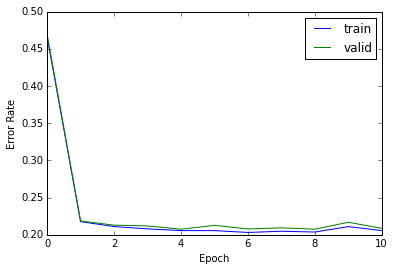

In [10]:
# Plot objective function.
matplotlib.pyplot.plot(info['train_y_01_loss'].val_record, label='train')
matplotlib.pyplot.plot(info['valid_y_01_loss'].val_record, label='valid')
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Error Rate')
matplotlib.pyplot.legend()

# Predictions on New Data, ROC Curves

In [8]:
# Create symbolic theano function to make predictions.
X = model.get_input_space().make_theano_batch()  # Loads entire dataset into memory.
Y = model.fprop( X )
f = theano.function( [X], Y )
yhat = f(dataset_valid.X)

AUC = 0.868761


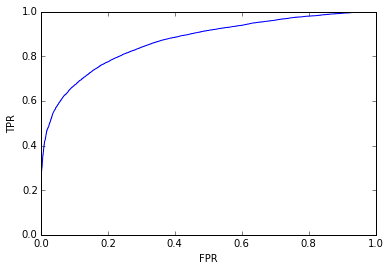

In [9]:
from sklearn import metrics
# Plot ROC curve and compute AUC.
fpr, tpr, thresholds = metrics.roc_curve(dataset_valid.y, yhat, pos_label=1)
matplotlib.pyplot.plot(fpr, tpr)
matplotlib.pyplot.xlabel('FPR')
matplotlib.pyplot.ylabel('TPR')
print 'AUC = %f' % metrics.auc(fpr, tpr)

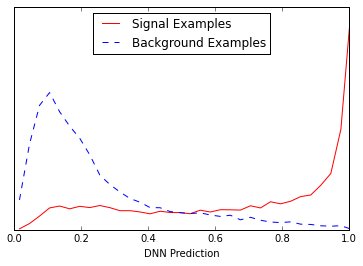

In [19]:
# Plot prediction distributions.
labels = ['NN']
colors = ['b', 'b']
step = .03
bins = numpy.arange(0,1+step,step)
y = dataset_valid.y
sig = yhat[y == 1]
bg = yhat[y == 0]
dist_sig = numpy.histogram(sig, bins)[0]
dist_bg = numpy.histogram(bg, bins)[0]

matplotlib.pyplot.plot(bins[:-1]+step/2.0, dist_sig, color='r', label='Signal Examples')
matplotlib.pyplot.plot(bins[:-1]+step/2.0, dist_bg, linestyle='--', color='b', label='Background Examples')
matplotlib.pyplot.ylabel('')
matplotlib.pyplot.yticks([])
matplotlib.pyplot.xlim([0,1])
matplotlib.pyplot.legend(loc='upper center')
matplotlib.pyplot.xlabel('DNN Prediction')

 # Inspect Model Weights
 We can inspect the learned parameters of our model.

Weight matrix has shape: (18, 100)


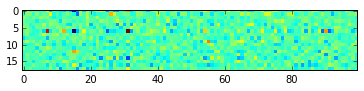

In [11]:
# Inspect weight parameters from first layer.
layer = model.layers[0]
W = layer.get_weights()
print 'Weight matrix has shape: ' + str(W.shape) # Shape is input dim by output dim
matplotlib.pyplot.imshow(W, interpolation='nearest')